# 0 Additional requirements
Run this only once:

In [1]:
#run this code once, too
import nltk
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


False

# 1 Intro
In topic modeling with gensim (https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/), we followed a structured workflow to build an insightful topic model based on the Latent Dirichlet Allocation (LDA) algorithm.

In this post, we will build the topic model using gensim’s native LdaModel and explore multiple strategies to effectively visualize the results using matplotlib plots.

I will be using a portion of the 20 Newsgroups dataset since the focus is more on approaches to visualizing the results.

Let’s begin by importing the packages and the 20 News Groups dataset.

In [2]:
pip install gensim==3.8.3

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sys
!{sys.executable} -m spacy download en_core_web_sm
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(["go",'from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


Traceback (most recent call last):
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/RXY/opt/anaconda3/lib/python3.9/socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._valid

In [4]:
!{sys.executable} -m spacy download en_core_web_sm

Traceback (most recent call last):
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/connection.py", line 174, in _new_conn
    conn = connection.create_connection(
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/util/connection.py", line 72, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/Users/RXY/opt/anaconda3/lib/python3.9/socket.py", line 954, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 8] nodename nor servname provided, or not known

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 703, in urlopen
    httplib_response = self._make_request(
  File "/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/urllib3/connectionpool.py", line 386, in _make_request
    self._valid

# 2 Import .json dataset


In [5]:
# Import dataset 
df = pd.read_json('/Users/RXY/Desktop/sarah/Preprocessed_YearOnly_lyrics_40_artists_3611_songs.json')
print(df.shape)  #> (2361, 3)
df.info

(3611, 4)


<bound method DataFrame.info of       year artist_name                            title   
0     2003     50 Cent                       In da Club  \
1     2003     50 Cent                     21 Questions   
2     2003     50 Cent            Many Men (Wish Death)   
3     2003     50 Cent                         P.I.M.P.   
4     2003     50 Cent                Patiently Waiting   
...    ...         ...                              ...   
3606  Unkn  Yasiin Bey          Auditorium w/ the Ruler   
3607  2009  Yasiin Bey               Twilight Speedball   
3608  2004  Yasiin Bey                       Excellence   
3609  Unkn  Yasiin Bey                        Wylin Out   
3610  2002  Yasiin Bey  Travellin’ Man (DJ Honda Remix)   

                                                 lyrics  
0     go go go go go go go shawty birthday gon party...  
1     new york city rockin cent got ta love na chill...  
2     damn got ta go get somethin eat man hungrier m...  
3     know heard ca get dol

# 3 Tokenize Sentences and Clean
Removing the emails, new line characters, single quotes and finally split the sentence into a list of words using gensim’s simple_preprocess(). Setting the deacc=True option removes punctuations.

In [6]:
def sent_to_words(sentences):
    for sent in sentences:
#         sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.lyrics.values.tolist()
print(data)
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['go', 'go', 'go', 'go', 'go', 'go', 'go', 'shawty', 'birthday', 'gon', 'party', 'like', 'birthday', 'gon', 'sip', 'like', 'birthday', 'know', 'give', 'birthday', 'find', 'club', 'bottle', 'full', 'bub', 'look', 'mami', 'got', 'takin', 'drug', 'havin', 'ai', 'makin', 'love', 'come', 'give', 'hug', 'gettin', 'rubbed', 'find', 'club', 'bottle', 'full', 'bub', 'look', 'mami', 'got', 'takin', 'drug', 'havin', 'ai', 'makin', 'love', 'come', 'give', 'hug', 'gettin', 'rubbed', 'pull', 'front', 'see', 'benz', 'dub', 'roll', 'twenty', 'deep', 'twenty', 'nine', 'club', 'yeah', 'heard', 'dre', 'na', 'show', 'love', 'sell', 'like', 'eminem', 'na', 'woo', 'look', 'homie', 'ai', 'nothin', 'changed', 'see', 'xzibit', 'cut', 'hey', 'roll', 'weed', 'roll', 'watch', 'move', 'mistake', 'player', 'pimp', 'hit', 'shell', 'walk', 'limp', 'aight', 'hood', 'sayin', 'hot', 'like', 'love', 'like', 'love', 'pac', 'holla', 'new', 'york', 'tell', 'loco', 'yeah', 'plan', 'put', 'rap', 'game', 'chokehold', 'fully',

# 4 Build the Bigram, Trigram Models and Lemmatize
Let’s form the bigram and trigrams using the Phrases model. This is passed to Phraser() for efficiency in speed of execution.

Next, lemmatize each word to its root form, keeping only nouns, adjectives, verbs and adverbs.

We keep only these POS tags because they are the ones contributing the most to the meaning of the sentences. Here, I use spacy for lemmatization.

In [7]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# 5 Build the Topic Model

In [8]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.087*"wit" + 0.038*"murder" + 0.029*"arrange" + 0.021*"school" + '
  '0.021*"motivate" + 0.018*"sayin" + 0.015*"job" + 0.015*"cha" + 0.012*"cut" '
  '+ 0.012*"crackin"'),
 (1,
  '0.064*"let" + 0.045*"baby" + 0.045*"love" + 0.026*"give" + 0.019*"way" + '
  '0.018*"feel" + 0.017*"girl" + 0.013*"man" + 0.013*"thing" + 0.012*"show"'),
 (2,
  '0.033*"life" + 0.022*"day" + 0.022*"never" + 0.021*"live" + 0.021*"world" + '
  '0.021*"die" + 0.019*"black" + 0.019*"man" + 0.018*"time" + 0.014*"feel"'),
 (3,
  '0.038*"ai" + 0.028*"back" + 0.025*"money" + 0.018*"real" + 0.017*"game" + '
  '0.017*"big" + 0.014*"ride" + 0.013*"ghetto" + 0.013*"gettin" + 0.011*"boy"'),
 (4,
  '0.030*"time" + 0.025*"rock" + 0.020*"high" + 0.014*"mind" + 0.014*"start" + '
  '0.013*"step" + 0.013*"hear" + 0.013*"fly" + 0.012*"check" + 0.012*"break"'),
 (5,
  '0.018*"leave" + 0.016*"still" + 0.014*"cause" + 0.014*"hard" + 0.013*"stop" '
  '+ 0.013*"place" + 0.012*"face" + 0.011*"people" + 0.011*"back" + '
  '0.00

## Get optimal topic number

In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=20, step=5)


In [ ]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
limit=20; start=2; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


## Wordclouds

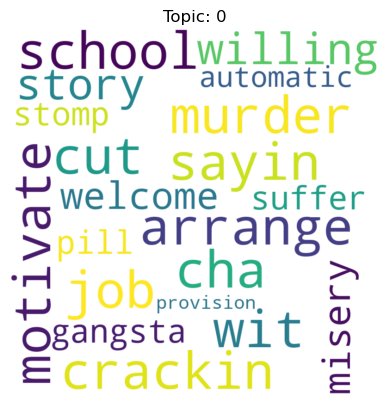

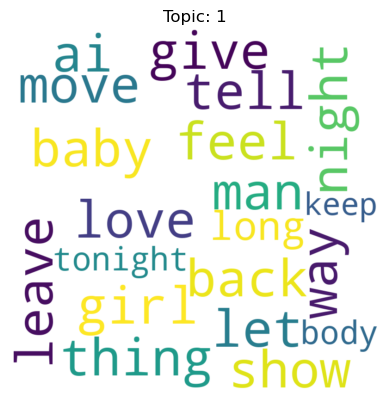

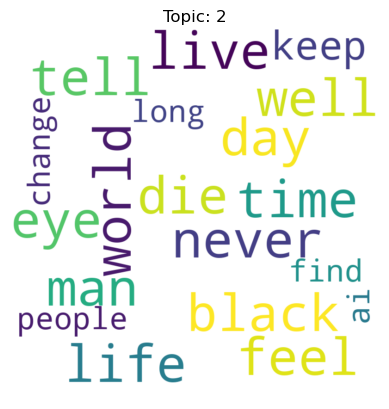

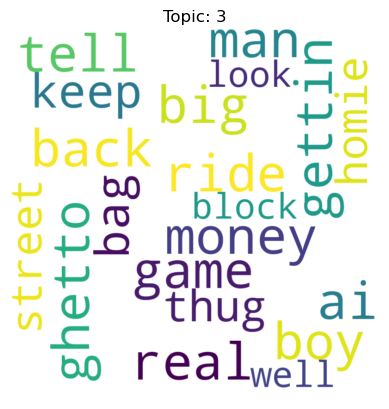

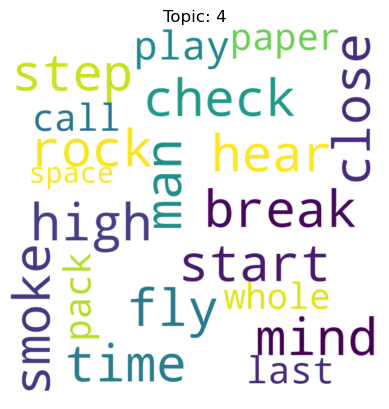

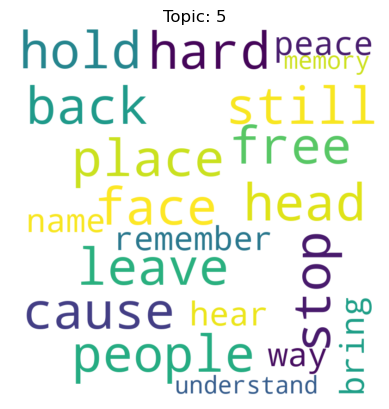

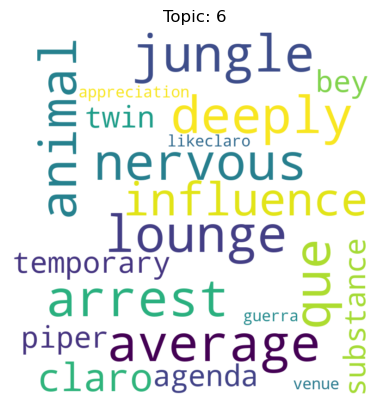

In [13]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import matplotlib.colors as mcolors

for topic_id, topic in enumerate(lda_model.print_topics(num_topics=7, num_words=20)):
    topic_words = " ".join([word.split("*")[1].strip() for word in topic[1].split(" + ")])
    wordcloud = WordCloud(width=800, height=800, random_state=21, max_font_size=110,background_color="white").generate(topic_words)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic: {}".format(topic_id))
    plt.show()

# 9 Word Clouds of Top N Keywords in Each Topic
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

## Word Counts of Topic Keywords

/var/folders/18/wh2965hn0rdb7ypx_vjgmhmh0000gn/T/ipykernel_9533/2491738362.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


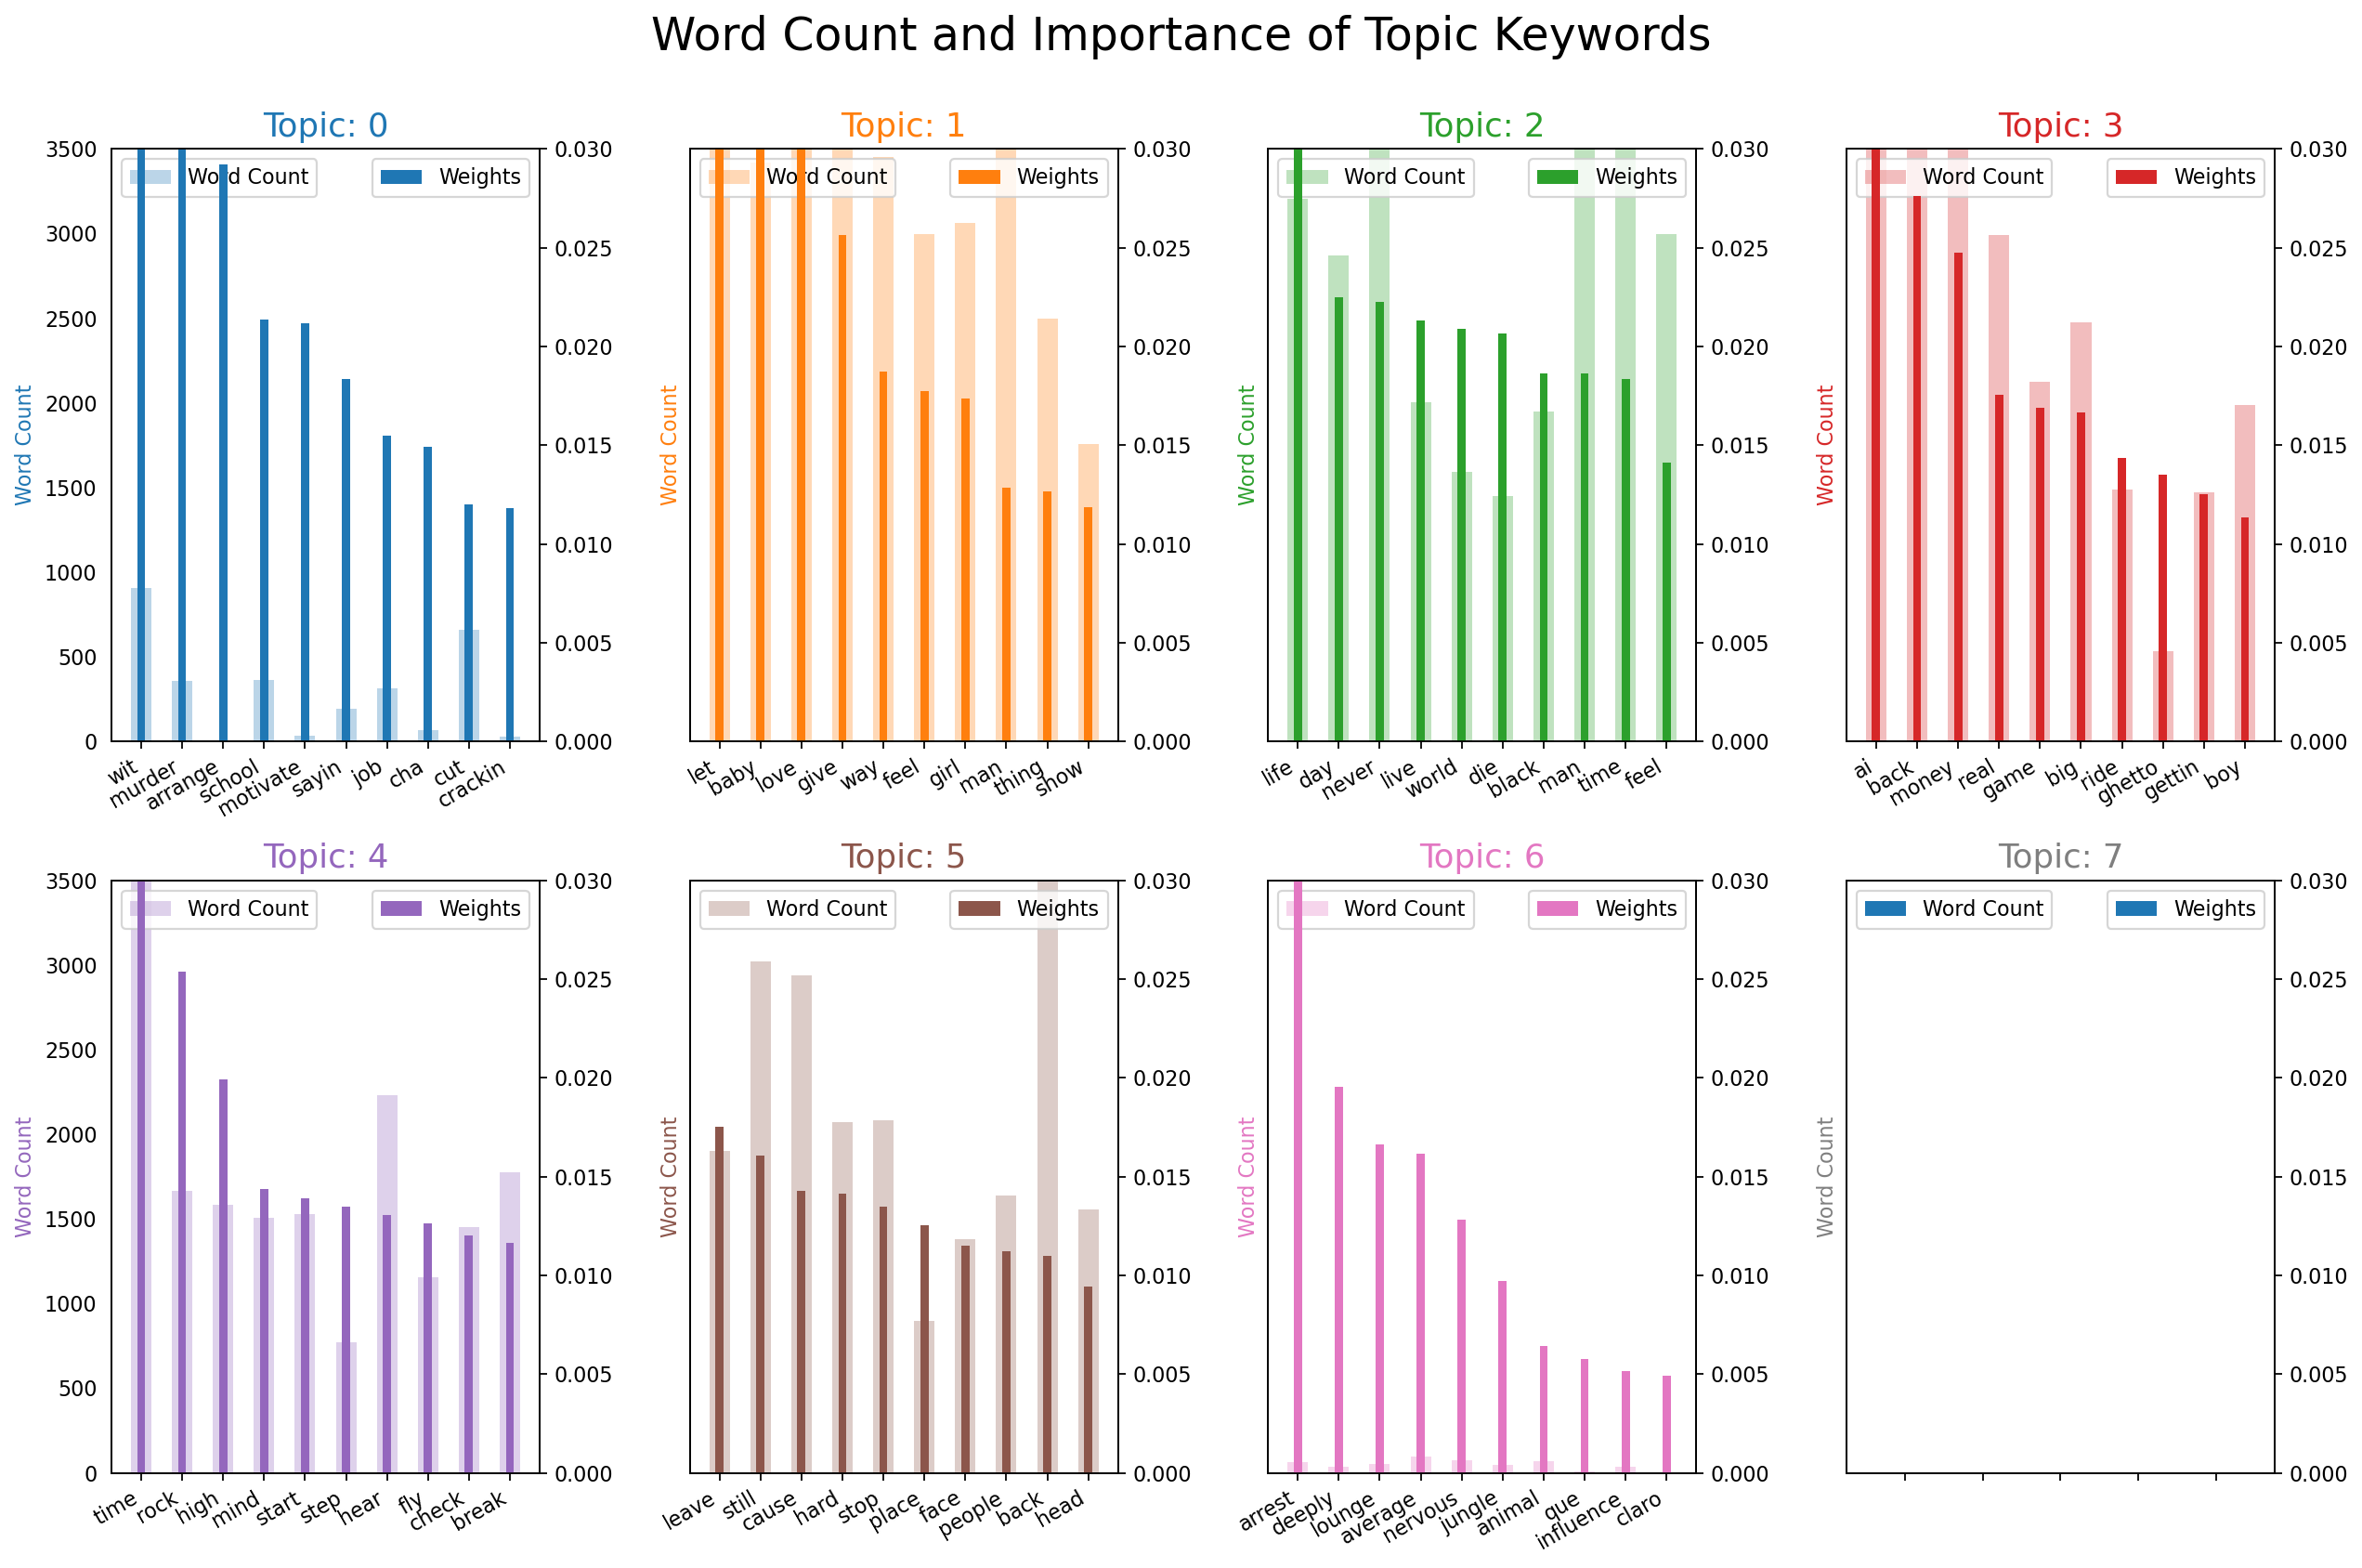

In [14]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()


# PyLDAvis

In [15]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(np.__version__) < '1.13':
/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/RXY/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py:36: DeprecationWarning: distutils Version classes are deprecated. Use p

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.174298 -0.033931       1        1  23.794703
5      0.136118 -0.175158       2        1  22.219476
2      0.137625  0.022886       3        1  18.593070
4     -0.029919  0.376986       4        1  16.468178
1      0.181382 -0.044556       5        1  16.244158
0     -0.347043 -0.095689       6        1   2.443130
6     -0.252461 -0.050539       7        1   0.237286, topic_info=                Term         Freq        Total Category  logprob  loglift
53               let  7949.000000  7949.000000  Default  30.0000  30.0000
263             baby  4649.000000  4649.000000  Default  29.0000  29.0000
57              love  4589.000000  4589.000000  Default  28.0000  28.0000
54              life  3866.000000  3866.000000  Default  27.0000  27.0000
86              time  5469.000000  5469.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
8300     retribution     0.634104    19.091147   Topic7  -7.7639   2.6389
4342   freaky_freaky     0.299118     7.714658   Topic7  -8.5153   2.7936
8836          detain     0.215476     7.494690   Topic7  -8.8433   2.4946
24073        bonanza     0.180762     3.451087   Topic7  -9.0190   3.0944
10729       landlord     0.210808     8.547875   Topic7  -8.8652   2.3412

[385 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
2894      7  0.823332  agenda
1         1  0.664023      ai
1         2  0.093506      ai
1         3  0.109110      ai
1         5  0.133267      ai
...     ...       ...     ...
161       2  0.234424    work
161       5  0.546432    work
709       3  0.999679   world
1142      1  0.473939   young
1142      3  0.525385   young

[519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 3, 5, 2, 1, 7])